In [1]:
!nvidia-smi

Fri Nov 22 06:54:10 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 556.13                 Driver Version: 556.13         CUDA Version: 12.5     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce GTX 1650      WDDM  |   00000000:01:00.0 Off |                  N/A |
| N/A   42C    P8              2W /   30W |      14MiB /   4096MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

Found 4000 images.


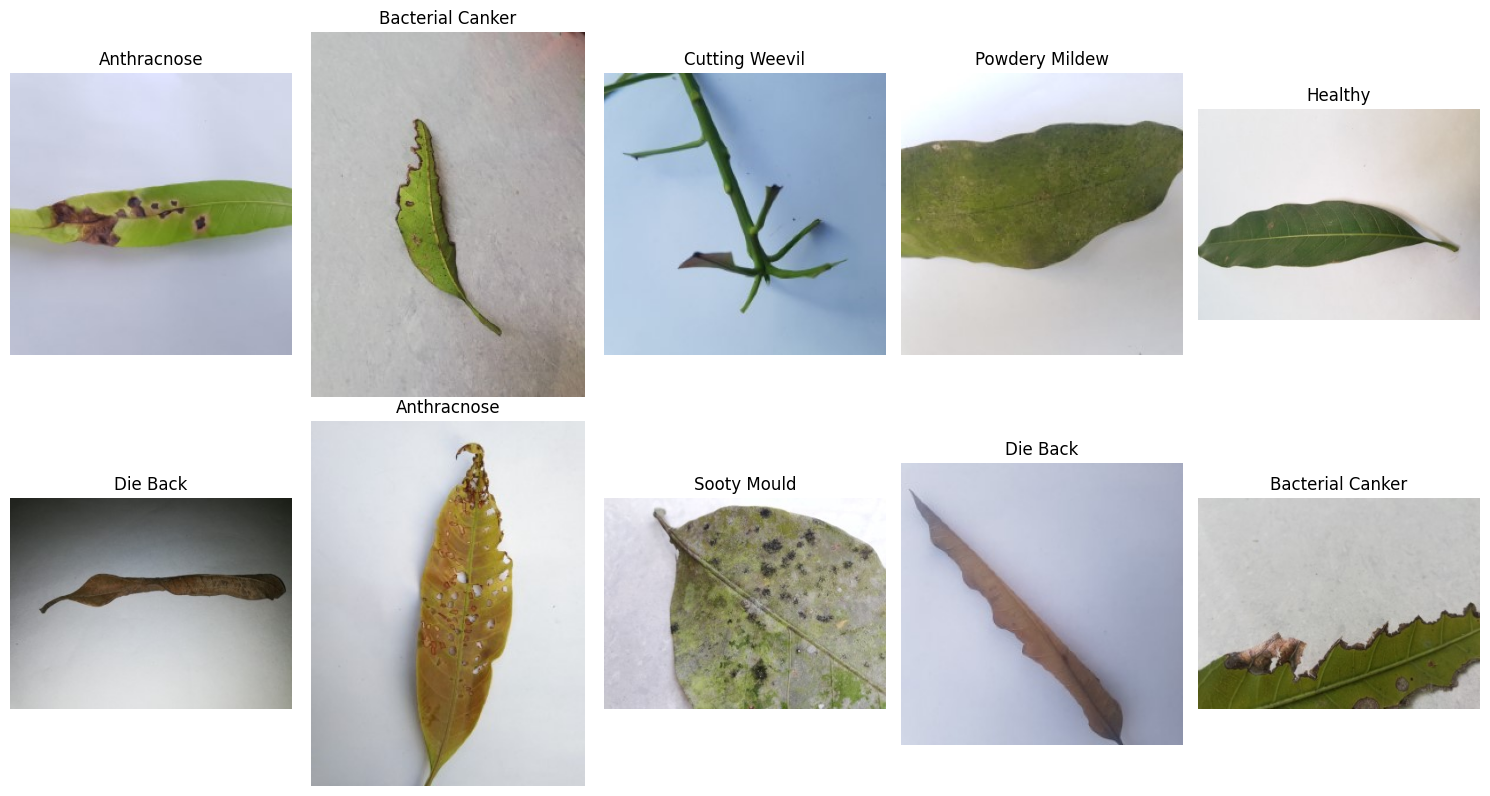

In [9]:
import glob
import os
import cv2 as cv 
import random
from PIL import Image 
import matplotlib.pyplot as plt

path = '../dataset'

image_files = glob.glob(os.path.join(path, "**/*.jpg"), recursive=True)

if image_files:
    print(f"Found {len(image_files)} images.")

    # Random sampling
    random.shuffle(image_files)

    plt.figure(figsize=(15, 8))
    for i, image_file in enumerate(image_files[:10]):
        img = Image.open(image_file)
        plt.subplot(2, 5, i + 1)
        plt.imshow(img)
        plt.title(os.path.basename(os.path.dirname(image_file)))  # Show the class name as title
        plt.axis('off')

    plt.tight_layout()
    plt.show()
else:
    print("No images found in the dataset.")

In [10]:
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import numpy as np

DATA_DIR = '../dataset'
IMG_SIZE = (224,224)

def load_data(data_dir):
    images, labels = [], []
    for label in os.listdir(data_dir):
        class_dir = os.path.join(data_dir, label)
        if os.path.isdir(class_dir):
            for file in os.listdir(class_dir):
                img_path = os.path.join(class_dir, file)
                img = cv.imread(img_path)
                if img is not None:
                    img = cv.resize(img, IMG_SIZE)
                    images.append(img)
                    labels.append(label)
    return np.array(images), np.array(labels)

# Muat data
X, y = load_data(DATA_DIR)

# Encoding label
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
y_categorical = to_categorical(y_encoded)

# Membagi data menjadi train dan test
X_train, X_test, y_train, y_test = train_test_split(X, y_categorical, test_size=0.2, random_state=42)

In [3]:
from keras.models import load_model

model = load_model('../saved_model')

In [11]:

from keras.layers import Normalization

derp = load_model('../saved_model')

# Evaluasi model
loss, accuracy = derp.evaluate(X_test, y_test)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

# Fungsi untuk menyoroti gejala penyakit pada daun
def highlight_symptoms(image):
    hsv = cv.cvtColor(image, cv.COLOR_BGR2HSV)
    lower_green = np.array([35, 40, 40])
    upper_green = np.array([85, 255, 255])
    green_mask = cv.inRange(hsv, lower_green, upper_green)
    green_areas = cv.bitwise_and(image, image, mask=green_mask)

    gray = cv.cvtColor(green_areas, cv.COLOR_BGR2GRAY)
    _, dark_areas_mask = cv.threshold(gray, 70, 255, cv.THRESH_BINARY_INV)

    highlighted_img = cv.cvtColor(green_areas, cv.COLOR_BGR2RGB)
    highlighted_img[dark_areas_mask == 255] = [255, 0, 0]  # Highlight with blue color
    return highlighted_img

# Fungsi untuk memprediksi dan menampilkan hasil
def predict_and_display(img_path, model, label_encoder):
    img = cv.imread(img_path)
    if img is None:
        print(f"Error: Image not found at {img_path}")
        return None

    img_resized = cv.resize(img, IMG_SIZE)
    img_array = np.expand_dims(img_resized, axis=0)

    prediction = model.predict(img_array)
    predicted_class = np.argmax(prediction, axis=1)[0]
    disease_name = label_encoder.classes_[predicted_class]

    highlighted_img = highlight_symptoms(img_resized)

    # Tampilkan gambar asli dan gambar yang disorot
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))
    axs[0].imshow(cv.cvtColor(img_resized, cv.COLOR_BGR2RGB))
    axs[0].set_title("Original Leaf")
    axs[1].imshow(highlighted_img)
    axs[1].set_title(f"Disease Highlighted: {disease_name}")
    for ax in axs:
        ax.axis("off")
    plt.show()

    return disease_name


25/25 [==============================] - 19s 633ms/step - loss: 9.1425e-05 - accuracy: 1.0000
Test Loss: 0.0001
Test Accuracy: 1.0000
